In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.409396
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ W는 0에 가까운 값들로 초기화 되기 때문에, exp연산을 거치면 모든 score는 1에 가까운 값이 되어 버린다(= $\frac{e^0}{e^0+e^0\cdots e^0}$).(여기서 분모의 항 개수는 클래스의 개수와 같음) 따라서 softmax를 거친 값은 1/cls_num이고 CIFAR-10의 class 수는 10개 이므로 loss는 -log(1/10)이 된다. (각 i에 대해 loss값은 모두 -log(1/10)이므로 평균을 내도 같음)


In [22]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.647606 analytic: 1.647605, relative error: 5.246605e-08
numerical: 0.219685 analytic: 0.219685, relative error: 6.501047e-08
numerical: 4.074416 analytic: 4.074416, relative error: 8.040670e-09
numerical: -0.301117 analytic: -0.301117, relative error: 6.337924e-08
numerical: -0.171699 analytic: -0.171699, relative error: 1.643863e-07
numerical: 1.737488 analytic: 1.737488, relative error: 6.081484e-08
numerical: -2.234331 analytic: -2.234331, relative error: 2.538201e-08
numerical: -0.020800 analytic: -0.020800, relative error: 1.989140e-06
numerical: 2.036283 analytic: 2.036283, relative error: 2.241231e-08
numerical: 0.485647 analytic: 0.485647, relative error: 1.612811e-07
numerical: -3.488762 analytic: -3.488762, relative error: 2.287712e-10
numerical: 0.267428 analytic: 0.267428, relative error: 1.202277e-07
numerical: 1.925669 analytic: 1.925669, relative error: 1.068078e-08
numerical: -0.215518 analytic: -0.215518, relative error: 2.672451e-07
numerical: -0.132131 a

In [23]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.409396e+00 computed in 0.262470s
vectorized loss: 2.409396e+00 computed in 0.010948s
Loss difference: 0.000000
Gradient difference: 0.000000


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-6, 1e-7, 2e-7]  # [1e-7, 5e-7]
regularization_strengths = [1e3, 1e4, 1.5e4]  # [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)

        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 36.200022
iteration 100 / 1500: loss 22.897072
iteration 200 / 1500: loss 15.559158
iteration 300 / 1500: loss 10.875541
iteration 400 / 1500: loss 7.867069
iteration 500 / 1500: loss 5.801543
iteration 600 / 1500: loss 4.525786
iteration 700 / 1500: loss 3.674247
iteration 800 / 1500: loss 3.054136
iteration 900 / 1500: loss 2.610523
iteration 1000 / 1500: loss 2.323527
iteration 1100 / 1500: loss 2.235826
iteration 1200 / 1500: loss 2.075116
iteration 1300 / 1500: loss 1.963561
iteration 1400 / 1500: loss 1.827778
iteration 0 / 1500: loss 312.818703
iteration 100 / 1500: loss 7.314134
iteration 200 / 1500: loss 2.131158
iteration 300 / 1500: loss 2.056744
iteration 400 / 1500: loss 1.924737
iteration 500 / 1500: loss 2.001879
iteration 600 / 1500: loss 2.040509
iteration 700 / 1500: loss 2.024086
iteration 800 / 1500: loss 1.920462
iteration 900 / 1500: loss 1.978528
iteration 1000 / 1500: loss 2.034234
iteration 1100 / 1500: loss 2.076393
iteration 1200 / 15

In [45]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.390000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ SVM loss에서 loss 값은 $\max (0, s_j - s_{y[i]} +1)$ 으로, 정답 score가 다른 score보다 1 이상 높으면 loss를 0으로 준다. 따라서, 이러한 조건에 해당하는 새로운 data point를 넣으면 SVM loss 값은 변하지 않는다. 그러나, Softmax loss는 0이 나오기가 불가능하다. softmax loss가 1이 되려면, 정답 class score가 아닌 다른 score들이 모두 0이 되어야 한다. 그런데, exp 값이 0이 되려면 score가 $-\infty$로 수렴해야 한다.



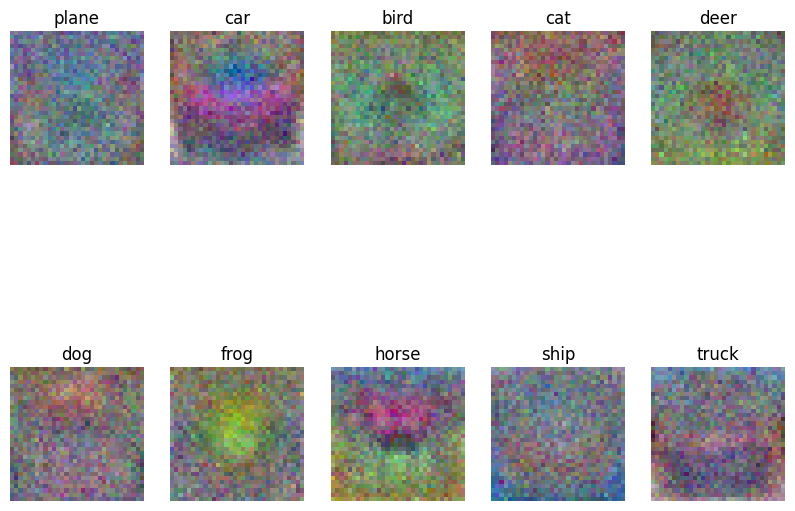

In [47]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])